In [338]:
import numpy as np
import pandas as pd
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf

## Reading the data

In [339]:
dir_name="./Datasets/sentiment labelled sentences/"
dirList=os.listdir(dir_name)
data=[]#list of dataframse
for file in dirList:
    if(file!='readme.txt'):
        df=pd.read_csv(dir_name+file,sep='\t',names=['tweet','label'])
        data.append(df)
data=pd.concat(data)

In [340]:
data.shape

(2748, 2)

In [341]:
data.head()

,tweet,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


#### Remove the null valuse

In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2748 non-null   object
 1   label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


No null values present

#### Visualize the distribution of the data

c:\users\gagan\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

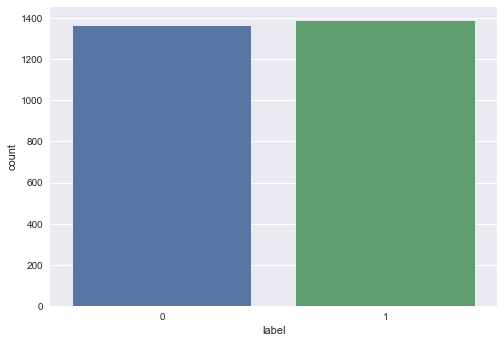

In [343]:
plt.style.use('seaborn')
sns.countplot('label',data=data)

## Data preprocessing using NLP

In [344]:

def preprocess_sentence(sen):
    # remove html tages, emails,websites 
    sen=re.sub('(\S*[@<>]\S*)',' ',sen)# replace with a single space
    #remove web site names
    sen=re.sub('(https://)*(www\.)*\S*(\.com)+',' ',sen)
    # remove more than 2 spcaces
    sen=re.sub('[\s+]',' ',sen)
    #remove alphanumeric words
    sen=re.sub("\S*[0-9]\S*",' ',sen)
   # words containing only alphabets and having length>=2 and lowercase
    return " ".join(re.findall('[a-zA-Z]{2,}',sen)).lower()


### Remove stopwords

In [345]:
stop_words=stopwords.words('english')

In [346]:
def remove_stopwords(sen):
    return " ".join([word for word in sen.split() if not word in  stop_words])

### Stemming
(lemmitizing can also be done)

In [347]:
stemmer=PorterStemmer()
def stem(sen):
    return " ".join([stemmer.stem(word) for word in sen.split()])

### Remove Contractions

In [348]:
def contractions(s):
    s = re.sub("won\'t", "will not",s)
    s = re.sub("would\'t", "would not",s)
    s = re.sub("could\'t", "could not",s)
    s = re.sub("\'d", " would",s)
    s = re.sub("can\'t", "can not",s)
    s = re.sub("\'t", " not", s)
    s= re.sub("\'re", " are", s)
    s = re.sub("\'s", " is", s)
    s = re.sub("\'ll", " will", s)
    s = re.sub("\'t", " not", s)
    s = re.sub("\'ve", " have", s)
    s = re.sub("\'m", " am", s)
    return s

In [349]:
data['tweet']=data['tweet'].apply(lambda x:contractions(x))

In [350]:
data['tweet']=data['tweet'].apply(lambda x:preprocess_sentence(x))

In [351]:
data['tweet']=data['tweet'].apply(lambda x:remove_stopwords(x))

In [352]:
data['tweet']=data['tweet'].apply(lambda x:stem(x))

### Tokenize the string using TF-IDF

In [353]:

tranformer=TfidfVectorizer()
data_tf=tranformer.fit_transform(data['tweet']).toarray()
print(data_tf.shape)
# print(tranformer.vocabulary_)
inv_vocab=dict( (i,j) for j,i in tranformer.vocabulary_.items())

(2748, 3848)


In [354]:
combined_data=np.hstack((data_tf,np.array(data['label']).reshape(-1,1)))

In [355]:
combined_data.shape

(2748, 3849)

## shuffle the data and split it

In [356]:
np.random.seed(100)
np.random.shuffle(combined_data)
split=0.8
split=int(split*combined_data.shape[0])
x_train=combined_data[0:split,:-1]
x_test=combined_data[split:,:-1]
y_train=combined_data[0:split,-1]
y_test=combined_data[split:,-1]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(2198, 3848) (2198,) (550, 3848) (550,)


## Neural Networks using keras

In [367]:
# kernel_regularizer=keras.regularizers.l1(0.000)
model = Sequential()
model.add(Dense(10, input_dim=x_train.shape[1], activation="relu",
                kernel_regularizer=keras.regularizers.l1(0.0006),
                kernel_initializer=keras.initializers.Identity()))
model.add(Dense(10, activation="relu",
                kernel_regularizer=keras.regularizers.l1(0.0006),
         kernel_initializer=keras.initializers.Identity()))
model.add(Dense(1, activation="sigmoid",
                kernel_regularizer=keras.regularizers.l1(0.00006),
        kernel_initializer=keras.initializers.Identity()))

In [368]:
optimizer=tf.keras.optimizers.SGD(0.5)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer,
              metrics=[keras.metrics.binary_accuracy]) #compile model
history=model.fit(x_train,y_train, epochs=500, batch_size=50,validation_data=(x_test[0:200],y_test[0:200]))  #training

Epoch 1/500
44/44 [==============================] - 1s 9ms/step - loss: 0.7064 - binary_accuracy: 0.4895 - val_loss: 0.7058 - val_binary_accuracy: 0.5000
Epoch 2/500
44/44 [==============================] - 0s 7ms/step - loss: 0.7068 - binary_accuracy: 0.4859 - val_loss: 0.7057 - val_binary_accuracy: 0.5050
Epoch 3/500
44/44 [==============================] - 0s 5ms/step - loss: 0.7069 - binary_accuracy: 0.4986 - val_loss: 0.7056 - val_binary_accuracy: 0.5050
Epoch 4/500
44/44 [==============================] - 0s 4ms/step - loss: 0.7064 - binary_accuracy: 0.4932 - val_loss: 0.7057 - val_binary_accuracy: 0.5000
Epoch 5/500
44/44 [==============================] - 0s 5ms/step - loss: 0.7063 - binary_accuracy: 0.4850 - val_loss: 0.7053 - val_binary_accuracy: 0.5000
Epoch 6/500
44/44 [==============================] - 0s 5ms/step - loss: 0.7065 - binary_accuracy: 0.4700 - val_loss: 0.7057 - val_binary_accuracy: 0.5000
Epoch 7/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6990 - binary_accuracy: 0.4995 - val_loss: 0.6981 - val_binary_accuracy: 0.5000
Epoch 54/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6986 - binary_accuracy: 0.4854 - val_loss: 0.6981 - val_binary_accuracy: 0.5000
Epoch 55/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6987 - binary_accuracy: 0.4909 - val_loss: 0.6980 - val_binary_accuracy: 0.5000
Epoch 56/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6987 - binary_accuracy: 0.4841 - val_loss: 0.6976 - val_binary_accuracy: 0.5000
Epoch 57/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6983 - binary_accuracy: 0.4964 - val_loss: 0.6976 - val_binary_accuracy: 0.5000
Epoch 58/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6980 - binary_accuracy: 0.4904 - val_loss: 0.6980 - val_binary_accuracy: 0.5000
Epoch 59/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6

44/44 [==============================] - 0s 4ms/step - loss: 0.6951 - binary_accuracy: 0.5014 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 106/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6954 - binary_accuracy: 0.4986 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 107/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6953 - binary_accuracy: 0.4968 - val_loss: 0.6948 - val_binary_accuracy: 0.5000
Epoch 108/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6952 - binary_accuracy: 0.4995 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 109/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6954 - binary_accuracy: 0.4986 - val_loss: 0.6950 - val_binary_accuracy: 0.5000
Epoch 110/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6958 - binary_accuracy: 0.4886 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 111/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6947 - binary_accuracy: 0.5032 - val_loss: 0.6950 - val_binary_accuracy: 0.5000
Epoch 158/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6952 - binary_accuracy: 0.5032 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 159/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6948 - binary_accuracy: 0.5177 - val_loss: 0.6969 - val_binary_accuracy: 0.5000
Epoch 160/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6955 - binary_accuracy: 0.4823 - val_loss: 0.6948 - val_binary_accuracy: 0.5000
Epoch 161/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6956 - binary_accuracy: 0.4732 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 162/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6957 - binary_accuracy: 0.4786 - val_loss: 0.6946 - val_binary_accuracy: 0.5000
Epoch 163/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 5ms/step - loss: 0.6954 - binary_accuracy: 0.4914 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 210/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6955 - binary_accuracy: 0.4904 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 211/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6957 - binary_accuracy: 0.4795 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 212/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6949 - binary_accuracy: 0.5023 - val_loss: 0.6949 - val_binary_accuracy: 0.5000
Epoch 213/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6947 - binary_accuracy: 0.5023 - val_loss: 0.6963 - val_binary_accuracy: 0.5000
Epoch 214/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6954 - binary_accuracy: 0.4932 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 215/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6954 - binary_accuracy: 0.4895 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 262/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6956 - binary_accuracy: 0.4995 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 263/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6957 - binary_accuracy: 0.4904 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 264/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6953 - binary_accuracy: 0.4850 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 265/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6950 - binary_accuracy: 0.4923 - val_loss: 0.6948 - val_binary_accuracy: 0.5000
Epoch 266/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6955 - binary_accuracy: 0.4850 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 267/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6959 - binary_accuracy: 0.4950 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 314/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6949 - binary_accuracy: 0.5105 - val_loss: 0.6955 - val_binary_accuracy: 0.5000
Epoch 315/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6955 - binary_accuracy: 0.4841 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 316/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6956 - binary_accuracy: 0.4877 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 317/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6954 - binary_accuracy: 0.4904 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 318/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6958 - binary_accuracy: 0.4941 - val_loss: 0.6946 - val_binary_accuracy: 0.5000
Epoch 319/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6956 - binary_accuracy: 0.4813 - val_loss: 0.6947 - val_binary_accuracy: 0.5000
Epoch 366/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6949 - binary_accuracy: 0.5059 - val_loss: 0.6960 - val_binary_accuracy: 0.5000
Epoch 367/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6953 - binary_accuracy: 0.4959 - val_loss: 0.6946 - val_binary_accuracy: 0.5000
Epoch 368/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6956 - binary_accuracy: 0.4995 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 369/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6952 - binary_accuracy: 0.4986 - val_loss: 0.6951 - val_binary_accuracy: 0.5000
Epoch 370/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6957 - binary_accuracy: 0.4732 - val_loss: 0.6953 - val_binary_accuracy: 0.5000
Epoch 371/500
44/44 [==============================] - 0s 4ms/step - los

44/44 [==============================] - 0s 5ms/step - loss: 0.6950 - binary_accuracy: 0.4914 - val_loss: 0.6949 - val_binary_accuracy: 0.5000
Epoch 418/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6955 - binary_accuracy: 0.4895 - val_loss: 0.6946 - val_binary_accuracy: 0.5000
Epoch 419/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6944 - binary_accuracy: 0.5014 - val_loss: 0.6965 - val_binary_accuracy: 0.5000
Epoch 420/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6950 - binary_accuracy: 0.5168 - val_loss: 0.6947 - val_binary_accuracy: 0.5000
Epoch 421/500
44/44 [==============================] - 0s 5ms/step - loss: 0.6943 - binary_accuracy: 0.5205 - val_loss: 0.6964 - val_binary_accuracy: 0.5000
Epoch 422/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6951 - binary_accuracy: 0.5068 - val_loss: 0.6955 - val_binary_accuracy: 0.5000
Epoch 423/500
44/44 [==============================] - 0s 5ms/step - los

44/44 [==============================] - 0s 4ms/step - loss: 0.6956 - binary_accuracy: 0.4904 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 470/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6953 - binary_accuracy: 0.4923 - val_loss: 0.6952 - val_binary_accuracy: 0.5000
Epoch 471/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6948 - binary_accuracy: 0.5077 - val_loss: 0.6953 - val_binary_accuracy: 0.5000
Epoch 472/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6953 - binary_accuracy: 0.4886 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 473/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6945 - binary_accuracy: 0.5105 - val_loss: 0.6961 - val_binary_accuracy: 0.5000
Epoch 474/500
44/44 [==============================] - 0s 4ms/step - loss: 0.6953 - binary_accuracy: 0.4868 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 475/500
44/44 [==============================] - 0s 4ms/step - los

In [369]:
print(model.evaluate(x_train,y_train))
print(model.evaluate(x_test,y_test))

69/69 [==============================] - 0s 4ms/step - loss: 0.6950 - binary_accuracy: 0.4977
[0.6950116753578186, 0.4977252185344696]
18/18 [==============================] - 0s 4ms/step - loss: 0.6957 - binary_accuracy: 0.4873
[0.6956552267074585, 0.4872727394104004]


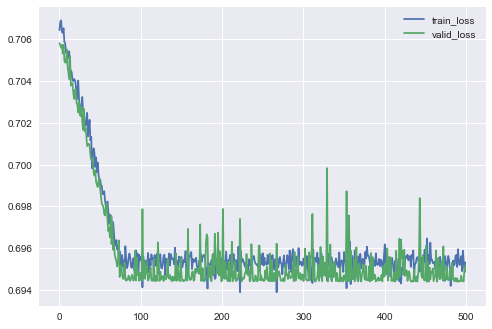

In [370]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='valid_loss')
plt.legend()
plt.show()

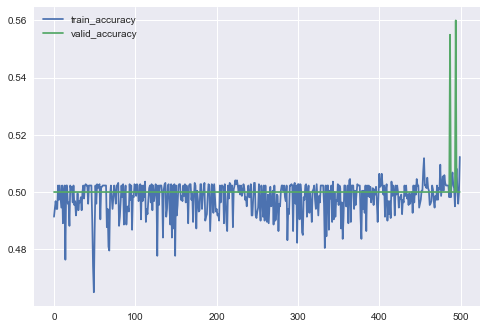

In [366]:
plt.plot(history.history['binary_accuracy'],label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'],label='valid_accuracy')
plt.legend()
plt.show()
